## Classifying movie reviews: A binary classification example  🎞️
---

Two-class classification, or binary clasifcation,is the modt widely applied kind of machine-learning problem.In theis we'll learn to classify movie review as postive or negative based on text content of the reveiws.

## The IMDB dataset  🗃️
---

It is a set of 50,000 highly polarized reviews from the Internet Movie Database.They're split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.  

Why use seprate training and test sets?Because you should never test a machine learning model on the same data that you used to train it!Just because a model performs well on its traing data doesn't means it will perform well on data it has never seen; and what you care about is your model's performance on new data.For instance, it is merly possible that your model could end up memorizing a mapping between the training samples and their targets which could be useless for the task of predicting targets for data the model has never seen before.  

This data has already been processed: the reveiws has been turned into sequence of integers,where each integer stands fir a specific word in dictionary.



#### 1. Loading the IMDB dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import warnings
print("Tensorflow version: ",tf.__version__) ## verison of tensorflow
warnings.filterwarnings("ignore")

Tensorflow version:  2.4.1


In [3]:
## Loading datasets
from tensorflow.keras.datasets import imdb
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000,)

The argument `num_words=10000` means only keep 10,000 most frequently occuring words in the training data.Rare words will be discarded.This allow us to work with manageable size.  

The variable `train_data` and `test_data` are list of reviews; each review is a list of word indices(encoding a sequence of words). `train_labels` and `test_labels` are list of 0 and 1, where 0 stand for negative and 1 for positive.

In [4]:
train_data.shape,test_data.shape ### training and testing size

((25000,), (25000,))

In [5]:
print(train_data[0]) ## encoded sequence of words of 1 review --> this is a list

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
print(train_labels[0]) ## binary of postive or negative review

1


Because we're restricitng to the top 10,000 most frequents words, no words will exceed 10,000

In [7]:
print(max([max(sequence) for sequence in train_data]))

9999


Here is how we can qucikly decode one of these reviews back to english words.

In [1]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value,key)for (key,value) in word_index.items()]) ##reverse it mapping indegers to word
decoded_review = " ".join([reverse_word_index.get(i-3,'?')for i in train_data[0]]) ## indices 0,1,2 are "padding","start of sequence  and unknown"
print(decoded_review) ## 0th review

NameError: name 'imdb' is not defined

#### 2. Preparing the data 🥘
---

we can't feed lists of integers into a neural network.We have to turn lists into tensors. There are two ways to do that.  

- Pad your lists so that they all will have the same length, turn them into integer tensor of shape (samples,word_indices) and then use as the first layer in your network, a layer capable of handling such integer tensors (the embedding layer).  

- One hot encode your lists to turn them into vector of 0s and 1s. This would mean, for instance, turning the sequence `[3,5]` into a 10,000 dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then You could use the first layer in your network a `Dense layer`, capable of handling floating point vector data.

Lets's go with the latter solution to vectorize the data, which will do manually for maximum clarity.  

**Encoding the integer sequences into a binary matrix**

In [9]:
import numpy as np

def vectorize_sequences(sequences,dimension=int(10000)):
    results = np.zeros((len(sequences),10000)) ## creates a all zero matrix
    for i, sequence in enumerate(sequences):
        results[i,sequence] = 1 ## set specific indices to 1
    return results


In [10]:
x_train = vectorize_sequences(train_data) ## vectorizing training data
x_test = vectorize_sequences(test_data) ## testing data

**Here's what the sample looks like.** 🔎
___

In [11]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should vectorize our label.

In [12]:
y_train = np.array(train_labels).astype("float32")
y_test = np.array(test_labels).astype("float32")

In [13]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

Now the data is ready to feed into neural network.

#### Building your neural network 📦📦📦📦
---

The input data is vectors, and the labels are scalars(1s and 0s): this is the easiest setup you'll ever encounter.A type of network that performs well on such s problem is a simple stack of `fully connected (Dense) layers` with `relu` activation function: `Dense(16,activation="relu)`.  

The argument being passed to each dense layer(16) is the number of hidden units of a layer.Eaxh dense layer with relu activation implements the following chain of tensor operatios:

`output = relu(dot(w,input), + b)` 

Having 16 hidden units means the weight matrix `W` will have shape `(input_dimension,16)`: The dot product with `w` will project the input data onto a 16-dimensional represntation space( and then you'll add the bias vector b and apply relu opertaions).We can intutively understand the dimensionlity of our representation space as "how much freedom you are allowing the network to have when learning the internal represntation". Having more hidde units (a higher-dimensional represntation space) alllows your network to learn more-complex repsentations, but it makes hte network more computionally expensive and may lead to learning unwanted patterns (patterns taht will improve performance of the training data but not on test data.)  

>There are two architecture decisions to bemade about such a stack of `Dense` layers ❓:  
    How many layers to use ?
    How man hidden units to choose for each layer?  
    
In this we are goin to use two intermeddiate layer with 16 units each.  

A third layer taht will output the scalar predcition regarding the sentiment of current review.  

The intermediate layer will be `relu` as their activation function, and the final layer will use a sigmoid activation function so as to output a probablity a score between (0 and 1 indicating how likely the sample is to have  the target "1": how likley the review is to be positive.) A `relu` (rectified linear unit) is s function meant to zero out negative values, whereas sigmoid "squashes" arbitary value into `[0,1]` interval, outputting something as a probabiltiy.

#### The model defination
---

In [3]:
from tensorflow.keras import models,layers

model = models.Sequential()
model.add(layers.Dense(16,activation="relu",input_shape=(10000,))) ### 16 defines the dimension of weight matrix(16,10000)
model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

In [16]:
model.get_weights()

[array([[ 0.00047412,  0.00619369,  0.00326663, ..., -0.01629463,
         -0.00610616,  0.01007491],
        [ 0.01938096, -0.0005775 , -0.00220568, ..., -0.01737208,
         -0.01823393, -0.00377434],
        [ 0.01406508,  0.00854339,  0.01852968, ..., -0.00237148,
          0.00393913,  0.00972803],
        ...,
        [-0.01470048,  0.00586499, -0.01156728, ...,  0.01210576,
          0.00493172, -0.00685034],
        [-0.01946554,  0.01986859, -0.0087304 , ...,  0.00256978,
          0.00315435,  0.01492684],
        [-0.00767086,  0.02131751,  0.00532693, ..., -0.00540482,
         -0.02047692,  0.00391513]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([[ 0.07742283, -0.05839011, -0.38234222, -0.34573412,  0.16341195,
          0.3186669 ,  0.10775331, -0.07451543,  0.27410176, -0.3337612 ,
          0.11406437,  0.39397284, -0.03715917,  0.2027131 , -0.20735438,
         -0.3088567 ],
        [-0.33639

<img src="5.PNG" height="250" width="250">

### What are activation 🏃 functions, why are they necessary?
---

Without an activation function like `relu` (also called a non-linearity), the dense layer would consist of two linear operations- a dot product and an addition:  

`output = dot(w,input) +b`  
        
So the layer could only learn the linear transformations(**affine** transformations) of the input data: the hypothesis space of the layer would be the set of all possible linear tansformations of the input data into 16-dimensional space.Such as hypothesis space is too restricted amd wouldn't benefit from multiple leyers of representations,beacuse a  deep stack of linear layers would still implement a linear operations: adding more layers wouldn't extend the hypothesis space.  

In order to get access to a much richer hypothesis space that would benefit from deep repersentation, you need non-linearity, or activation function. `relu` is the most popular activation function in deep learning, bu there are many other candidates like: prelu,elu, and so on.

Finally, we need to choose a loss functions and an optimizer.Beacuse you're facing a binary classification problem and the output of your network is a probability ( end network with a single-unit layer with a sigmoid activation), it's best to use the  `binary_crossentropy` loss. It isn't the only viable choice: you could use, for instance, `mean_squared_error`.But crossentropy is usually the best chpice when you're deadling with models that outputs probablities.  
`Crossentropy` is a qunatity from the field of Information Theory that measure the distance between probability distributions or, in this case, between the ground-truth ditribution and predictions.  

Here's the step where you configure the model with the `rmsprop`and the `binary_crossentropy` loss functions. we will also monitor accuracy during the training.

#### Compiling the model
---



In [15]:
model.compile(optimizer="rmsprop",
             loss="binary_crossentropy",
             metrics=["accuracy"])

We are passing our optimizer, loss functions and metrics as string, which is possible because `rmsprop`,`binary_crossentropy` and `accuracy` are packaged as part of Keras.Sometimes you may want to configure the parametrs of optimizer or pass a custom loss function.The former can be done by passing an optimizer class instance as th optimizer argument.The latter can be done by passing functions objects as the loss and or metrics arguments.

#### Configuring the optimizer
___

In [16]:
from tensorflow.keras import optimizers
from tensorflow.keras import metrics,losses

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

#### Validating the approach
___

In order to monitor during training the accuracy of the model on data it has nerver seenbefor, you'll creata a validation set by setting apart 10,000 samples from the original training data.


**Listing validation set**

In [19]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [21]:
x_val,y_val

(array([[0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 1., 0., 0.]]),
 array([1., 0., 0., ..., 1., 0., 0.], dtype=float32))

In [30]:
partial_x_train.shape

(15000, 10000)

Now we will train the model for 20 epochs( 20 iteration over all samples in the x_train and y_train tensors), in minibatches of 512 samples. At the same time, you'll monitor loss and accuracy on the 10,000 samples that we set apart.This is done by passing validation data as the validation_data argument.  


[Understanding difference between epoch and batch](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

#### Training the model
---

In [22]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data = (x_val,y_val))

2022-01-08 08:33:12.660667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-08 08:33:12.904925: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


Epoch 1/20
30/30 [==============================] - 59s 1s/step - loss: 0.5830 - binary_accuracy: 0.6943 - val_loss: 0.3769 - val_binary_accuracy: 0.8643
Epoch 2/20
30/30 [==============================] - 1s 26ms/step - loss: 0.3098 - binary_accuracy: 0.9006 - val_loss: 0.3040 - val_binary_accuracy: 0.8837
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2210 - binary_accuracy: 0.9340 - val_loss: 0.2921 - val_binary_accuracy: 0.8815
Epoch 4/20
30/30 [==============================] - 1s 51ms/step - loss: 0.1688 - binary_accuracy: 0.9483 - val_loss: 0.2760 - val_binary_accuracy: 0.8886
Epoch 5/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1413 - binary_accuracy: 0.9534 - val_loss: 0.2844 - val_binary_accuracy: 0.8859
Epoch 6/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1103 - binary_accuracy: 0.9676 - val_loss: 0.2974 - val_binary_accuracy: 0.8833
Epoch 7/20
30/30 [==============================] - 1s 25ms/step - loss

___
Here we have choosen batch size of `512` and epoch as `20` this implies that `15000` training data is divided into `approx 30 minibatches of 512 samples in each`, this means that model weight will be updated after each batch of `512 samples`. Which is looped over `20` epoch which means each epoch will involve 30 batch or 30 weight updates in model.so there will we total `30*20 =600` times weight updation.

At the end of every epcoh, there is a slight pause as the model computes its losss and accuracy on the 10,000 samples of validation data.  

Calling `model.fit()` returns a history object,This object has a member history, which is a dictionary containing data about everything that happend during training.Let's look at it:



In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

This dictionary contain four enteries, One per metric that was monitered during **training** and during **validation**.

#### Plotting 📈📈 the training and validation loss
___

Let's use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy.

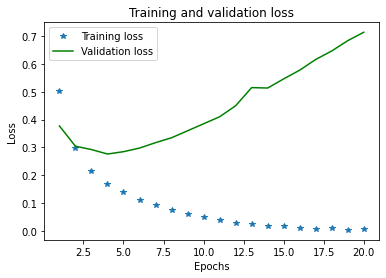

In [47]:
import matplotlib.pyplot as plt  

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]  

epochs = range(1,21)  

plt.plot(epochs,loss_values,"*",label="Training loss",) ## "bo"is for "blue dot"
plt.plot(epochs,val_loss_values,"b",label="Validation loss",color="green") ## "b" is for "solid blue line"
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


#### plotting the training and validation accuracy 📈📈
___

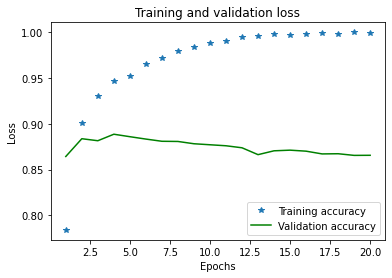

In [48]:
plt.clf()
accuracy_values = history_dict["binary_accuracy"]
val_accuracy_values = history_dict["val_binary_accuracy"]  


epochs = range(1,21)  

plt.plot(epochs,accuracy_values,"*",label="Training accuracy",) ## "bo"is for "blue dot"
plt.plot(epochs,val_accuracy_values,"b",label="Validation accuracy",color="green",) ## "b" is for "solid blue line"
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

As you can see, the training loss decrease with every epoch, and the training accuracy increases with every epoch, and the training accurcy increases with every epoch. That's what we expect hen runnung gradient optimization- the quantity you're trying to minimize should be less with every iteration. But that isn't case case for validation loss  and accuracy, they seen to peek at fourth epcoh. The model that perform better on the training data isn't necessarliy a model that will fo better on data it has has nver seenbefore.In precise term what you are seeing is `overfitting`: after the second epoch, we are overoptimizing on hte training data, and you end up learning representation that are specific to the training data and don't generalize to data outside of the training set.  

In this case to prevent overfitting you should stop training data after three epcohs.There are bunch of other techniques to mitigate overfitting.

#### Retraining the model from scratch
---

In [66]:
%%time
model = models.Sequential()
model.add(layers.Dense(16,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))  

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

history = model.fit(partial_x_train,partial_y_train,epochs=4,batch_size=512,validation_data=(x_val,y_val))

Epoch 1/4
30/30 [==============================] - 23s 363ms/step - loss: 0.6001 - accuracy: 0.7048 - val_loss: 0.4028 - val_accuracy: 0.8619
Epoch 2/4
30/30 [==============================] - 1s 49ms/step - loss: 0.3354 - accuracy: 0.9017 - val_loss: 0.3348 - val_accuracy: 0.8697
Epoch 3/4
30/30 [==============================] - 1s 28ms/step - loss: 0.2407 - accuracy: 0.9274 - val_loss: 0.2847 - val_accuracy: 0.8869
Epoch 4/4
30/30 [==============================] - 1s 27ms/step - loss: 0.1842 - accuracy: 0.9411 - val_loss: 0.2935 - val_accuracy: 0.8825
CPU times: user 16.4 s, sys: 18.6 s, total: 35 s
Wall time: 42 s


#### plotting training loss and validation loss
---

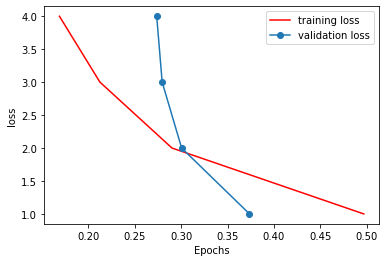

In [55]:
history_dict = history.history

train_loss = history_dict["loss"]
validation_loss = history_dict["val_loss"]

plt.plot(train_loss,[i for i in range(1,5)],color="red",label="training loss")
plt.plot(validation_loss,[i for i in range(1,5)],label="validation loss",marker="o")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#### Plot training and testing accuracy

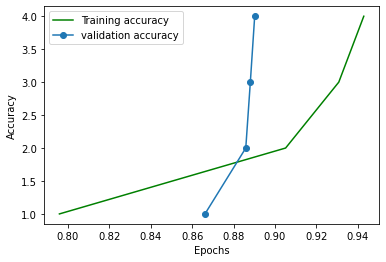

In [65]:
train_accuracy  = history_dict["accuracy"]
validation_accuracy  = history_dict["val_accuracy"]

plt.clf()
plt.plot(train_accuracy,[i for i in range(1,5)],color="green",label= "Training accuracy")
plt.plot(validation_accuracy,[i for i in range(1,5)],marker="o",label= "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Training model on whole data
___

In [68]:
model = models.Sequential()
model.add(layers.Dense(16,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))  

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

history = model.fit(x_train,y_train,epochs=4,batch_size=512,)


Epoch 1/4
49/49 [==============================] - 10s 18ms/step - loss: 0.5560 - accuracy: 0.7339
Epoch 2/4
49/49 [==============================] - 1s 16ms/step - loss: 0.2721 - accuracy: 0.9089
Epoch 3/4
49/49 [==============================] - 1s 17ms/step - loss: 0.2025 - accuracy: 0.9330
Epoch 4/4
49/49 [==============================] - 1s 18ms/step - loss: 0.1633 - accuracy: 0.9441


In [69]:
results = model.evaluate(x_test,y_test,)


782/782 [==============================] - 4s 3ms/step - loss: 0.2942 - accuracy: 0.8833


With such a simple network we are able to achive quite good accuracy.

#### Wrapping up 👋👋👋👋
---
1. Data needs a preprocessing befor feeding into the network, it can be encoded as binary and many other encoders are also available.  


2. Stacks of `Dense layers` with `relu` activations can solve a wide rangr of problems.  



3. In case of binary classification you rnetworks should end with dense layer with one unit and a sigmoid activation function.  



4. For sigmoid output he loss function you should use is `binary_Crossentropy`.  



5. The `rmsprop` optimizers is generally good enough choice for any problems.  



6. As the performance on training data increase, the model start geeting overfit and hence it won't perform well on unseen data.Be sure to always monitor the performace on the data outside the training set.